<a href="https://colab.research.google.com/github/charlieangriawan/is428/blob/main/flash_logistics_analysis_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd

# Importing libraries

import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
!pip install googletrans==4.0.0-rc1
import googletrans
from googletrans import Translator
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import itertools
import datetime
import re
import math

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [36]:
customers = pd.read_csv("olist_customers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
ordered_items = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
translated_names = pd.read_csv('product_category_name_translation.csv')

# Merging Datasets

In [39]:
# Filter to 3 states

geolocation = geolocation.loc[(geolocation["geolocation_state"] == "SP") | (geolocation["geolocation_state"] == "RJ") | (geolocation["geolocation_state"] == "MG")]

#Renaming the zip_code_prefix column to be the same across the three sheets
geolocation = geolocation.rename(columns={"geolocation_zip_code_prefix": "zip_code_prefix"})
sellers = sellers.rename(columns={"seller_zip_code_prefix": "zip_code_prefix"})
customers = customers.rename(columns={"customer_zip_code_prefix": "zip_code_prefix"})

#Joining sellers with geolocation and removing duplicate ids to have just one latitude and longitude per city 
#and zip code

sellers = pd.merge(sellers, geolocation[['zip_code_prefix','geolocation_lat','geolocation_lng']],\
                   on ='zip_code_prefix')
sellers = sellers.drop_duplicates(subset ="seller_id", keep = 'last') 

#Joining sellers with geolocation and removing duplicate ids to have just one latitude and longitude per city and zip code

customers = pd.merge(customers, geolocation[['zip_code_prefix','geolocation_lat','geolocation_lng']], \
                     on ='zip_code_prefix')
customers = customers.drop_duplicates(subset ="customer_id", keep = 'last') 

#Joining orders and customers
orders = pd.merge(orders, customers, on ='customer_id')

#Splitting orders into delivered and undelivered
undelivered_orders = orders.loc[orders['order_status'] != 'delivered']
delivered_orders = orders.loc[orders['order_status'] == 'delivered']

#Joining sellers and ordered
sellers = pd.merge(sellers,ordered_items, on ='seller_id')

#Joining orders and sellers and renaming some columns

completed_orders = pd.merge(delivered_orders,sellers, on ='order_id')
completed_orders = completed_orders.rename(columns={"zip_code_prefix_x": "zip_code_prefix_customer",
                                                   "zip_code_prefix_y": "zip_code_prefix_seller",
                                                   "geolocation_lat_x": "geolocation_lat_customer",
                                                   "geolocation_lat_y": "geolocation_lat_seller",
                                                   "geolocation_lng_x": "geolocation_lng_customer",
                                                   "geolocation_lng_y": "geolocation_lng_seller"})

#Joining orders and order reviews
completed_orders = pd.merge(completed_orders,order_reviews[['order_id','review_score']], on ='order_id')

#Joining orders and payments 
completed_orders = pd.merge(completed_orders,payments[['order_id','payment_type', 'payment_installments']], \
                            on ='order_id')

#Joining products and their English category names as the original category names are in Portuguese
products = pd.merge(products[['product_id', 'product_category_name']], translated_names, on ='product_category_name')

#Joining orders and product category names
completed_orders = pd.merge(completed_orders,products[['product_id', 'product_category_name_english']], \
                            on ='product_id')

# Remove duplicated entries
completed_orders = completed_orders.drop_duplicates(subset ="customer_id", keep = 'last') 
# completed_orders

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'geolocation_lat_x_x', 'geolocation_lat_y_x', 'geolocation_lng_x_x', 'geolocation_lng_y_x', 'zip_code_prefix_x'} in the result is deprecated and will raise a MergeError in a future version.



# Data Cleaning and Pre-processing

In [40]:
#Making dates date_time object, which is their appropriate data type
#Keeping only the date, and making sure it is a date-time object

for i in ['order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date']:
    completed_orders[i] = pd.to_datetime(completed_orders[i]).dt.date
    completed_orders[i] = pd.to_datetime(completed_orders[i])

# Remove rows with missing data
completed_orders = completed_orders.dropna()
completed_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id_x,zip_code_prefix_customer,...,geolocation_lng,order_item_id,product_id,shipping_limit_date,price,freight_value,review_score,payment_type,payment_installments,product_category_name_english
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,-46.442547,1,87285b34884572647811a353c7ac498a,2017-10-06,29.99,8.72,4,voucher,1,housewares
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15,2017-08-15,2017-08-17,2017-08-18,2017-08-28,3a51803cc0d012c3b5dc8b7528cb05f7,3366,...,-46.442547,1,87285b34884572647811a353c7ac498a,2017-08-21,29.99,7.78,4,credit_card,3,housewares
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02,2017-08-02,2017-08-04,2017-08-07,2017-08-15,ef0996a1a279c26e7ecbd737be23d235,2290,...,-46.442547,1,87285b34884572647811a353c7ac498a,2017-08-08,29.99,7.78,5,credit_card,1,housewares
5,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13,2018-02-13,2018-02-14,2018-02-16,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,-46.268059,1,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-19,19.90,8.72,5,credit_card,1,stationery
7,88abc7f56b29139888abe397ab368518,34348d655bdb46337f636994764b7ee7,delivered,2017-12-08,2017-12-12,2017-12-14,2018-01-23,2018-01-09,92f5b9a03b9ee33b719cdacbf591e0bc,24931,...,-46.268059,2,65266b2da20d04dbe00c5c2d3bb7859e,2017-12-18,19.90,14.10,1,boleto,1,stationery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63756,c2af225ac9a68a3c24500aa6fab006aa,f93c9e539a9705a57902c625b611e90c,delivered,2018-08-20,2018-08-20,2018-08-22,2018-08-27,2018-08-28,a3adfb1ef257529c6abe81be7726a63f,1454,...,-47.796544,1,dc6fe08afddfeb23ce334ce4cf5890eb,2018-08-22,30.99,12.88,5,credit_card,1,health_beauty
63757,f6f9344efc918f1e00ab84c014aa21d7,166478efeed4f9a861164b4ff5acfe8b,delivered,2017-05-20,2017-05-20,2017-05-25,2017-06-06,2017-06-21,b0f75567787a7483aadf695f5021e881,21741,...,-42.957042,1,af87aa3f5f2c05c8c4db6bee2088672b,2017-06-01,399.99,82.70,4,credit_card,6,furniture_mattress_and_upholstery
63759,e8fd20068b9f7e6ec07068bb7537f781,609b9fb8cad4fe0c7b376f77c8ab76ad,delivered,2017-08-10,2017-08-10,2017-08-18,2017-08-23,2017-08-31,fb9310710003399b031add3e55f34719,3318,...,-47.789122,2,0df37da38a30a713453b03053d60d3f7,2017-08-17,356.00,18.12,4,credit_card,10,sports_leisure
63760,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23,2017-02-23,2017-03-01,2017-03-06,2017-03-22,831ce3f1bacbd424fc4e38fbd4d66d29,5127,...,-48.838906,1,ea73128566d1b082e5101ce46f8107c7,2017-02-27,139.90,16.09,5,credit_card,3,furniture_decor


# Feature Engineering

In [41]:
#Checking if order was shipped and delivered on time
# shipping_limit_date: seller shipping limit date for handling the order over to the logistic partner
# order_delivered_carrier_date: order posting timestamp. When it was handled to the logistic partner
# order_delivered_customer_date: actual order delivery date to the customer
# order_estimated_delivery_date: estimated delivery date that was informed to customer at the purchase moment

completed_orders['shipped_on_time'] = completed_orders\
.order_delivered_carrier_date < completed_orders.shipping_limit_date
completed_orders['delivered_on_time'] = completed_orders\
.order_delivered_customer_date < completed_orders.order_estimated_delivery_date

#Checking days between each step in the funnel to see bottlenecks
completed_orders['days_taken_to_approve_transaction'] = (completed_orders.order_approved_at - completed_orders.order_purchase_timestamp).dt.days
completed_orders['days_taken_from_approval_to_drop_off'] = (completed_orders.order_delivered_carrier_date - completed_orders.order_approved_at).dt.days
completed_orders['days_taken_for_items_to_reach_customer_after_drop_off'] = (completed_orders.order_delivered_customer_date - completed_orders.order_delivered_carrier_date).dt.days
completed_orders['how_many_days_before_deadline_was_product_dropped'] = (completed_orders.shipping_limit_date - completed_orders.order_delivered_carrier_date).dt.days

completed_orders['days_customer_expected_to_wait_for_delivery'] = (completed_orders.order_estimated_delivery_date - completed_orders.order_purchase_timestamp).dt.days
completed_orders['actual_days_customer_waited_for_delivery'] = (completed_orders.order_delivered_customer_date - completed_orders.order_purchase_timestamp).dt.days
completed_orders['days_between_expected_delivery_and_actual_delivery'] = ( completed_orders.order_delivered_customer_date - completed_orders.order_estimated_delivery_date).dt.days

completed_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id_x,zip_code_prefix_customer,...,product_category_name_english,shipped_on_time,delivered_on_time,days_taken_to_approve_transaction,days_taken_from_approval_to_drop_off,days_taken_for_items_to_reach_customer_after_drop_off,how_many_days_before_deadline_was_product_dropped,days_customer_expected_to_wait_for_delivery,actual_days_customer_waited_for_delivery,days_between_expected_delivery_and_actual_delivery
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02,2017-10-04,2017-10-10,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,housewares,True,True,0,2,6,2,16,8,-8
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15,2017-08-15,2017-08-17,2017-08-18,2017-08-28,3a51803cc0d012c3b5dc8b7528cb05f7,3366,...,housewares,True,True,0,2,1,4,13,3,-10
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02,2017-08-02,2017-08-04,2017-08-07,2017-08-15,ef0996a1a279c26e7ecbd737be23d235,2290,...,housewares,True,True,0,2,3,4,13,5,-8
5,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13,2018-02-13,2018-02-14,2018-02-16,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,stationery,True,True,0,1,2,5,13,3,-10
7,88abc7f56b29139888abe397ab368518,34348d655bdb46337f636994764b7ee7,delivered,2017-12-08,2017-12-12,2017-12-14,2018-01-23,2018-01-09,92f5b9a03b9ee33b719cdacbf591e0bc,24931,...,stationery,True,False,4,2,40,4,32,46,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63756,c2af225ac9a68a3c24500aa6fab006aa,f93c9e539a9705a57902c625b611e90c,delivered,2018-08-20,2018-08-20,2018-08-22,2018-08-27,2018-08-28,a3adfb1ef257529c6abe81be7726a63f,1454,...,health_beauty,False,True,0,2,5,0,8,7,-1
63757,f6f9344efc918f1e00ab84c014aa21d7,166478efeed4f9a861164b4ff5acfe8b,delivered,2017-05-20,2017-05-20,2017-05-25,2017-06-06,2017-06-21,b0f75567787a7483aadf695f5021e881,21741,...,furniture_mattress_and_upholstery,True,True,0,5,12,7,32,17,-15
63759,e8fd20068b9f7e6ec07068bb7537f781,609b9fb8cad4fe0c7b376f77c8ab76ad,delivered,2017-08-10,2017-08-10,2017-08-18,2017-08-23,2017-08-31,fb9310710003399b031add3e55f34719,3318,...,sports_leisure,False,True,0,8,5,-1,21,13,-8
63760,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23,2017-02-23,2017-03-01,2017-03-06,2017-03-22,831ce3f1bacbd424fc4e38fbd4d66d29,5127,...,furniture_decor,False,True,0,6,5,-2,27,11,-16


# Delivery Data Analysis

In [42]:
#Splitting data into on-time and late deliveries

late_deliveries = completed_orders.loc[completed_orders.delivered_on_time == False]
ontime_deliveries = completed_orders.loc[completed_orders.delivered_on_time == True]

# Find the average days between estimated and actual delivery
product_delivery_times = completed_orders.groupby('product_category_name_english').mean()['days_between_expected_delivery_and_actual_delivery']
product_categories = completed_orders.product_category_name_english.unique()
p_deliv_time = pd.DataFrame(list(zip(product_categories,product_delivery_times)), columns = ['product_categories', 'product_delivery_times'])
p_deliv_time = p_deliv_time.sort_values(by =['product_delivery_times'])
p_deliv_time

,product_categories,product_delivery_times
29,fashion_bags_accessories,-17.666667
31,books_general_interest,-17.000000
54,costruction_tools_tools,-15.300000
27,home_confort,-14.583333
34,drinks,-14.315789
...,...,...
25,home_appliances,-9.416667
41,musical_instruments,-9.354839
36,small_appliances,-8.478261
14,furniture_decor,-8.117647


# Products with delays in inbound logistics processes have a higher percentage of being delivered late

In [43]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Pie(labels=['Late Deliveries','On Time Deliveries'],
                             values=[len(late_deliveries), len(ontime_deliveries)])])
fig.update_layout(
    title_text="Delivery Types")
fig.show()

In [44]:
# On Time Inbound Shipment: seller handed over products to logistics partner on time
# Late Inbound Shipment: seller did not hand over products to logistics partner on time
# On Time Outbound Shipment: logistics partner delivered products to customer on time
# Late On Time Outbound Shipment: logistics partner was late in delivering products to customer

animals=['Late Deliveries','On Time Deliveries']

fig1 = go.Figure(data=[
    go.Bar(name='On Time Inbound Shipment', x=animals, y=[
                                                  (late_deliveries.shipped_on_time.value_counts()[1]/len(late_deliveries)),
                                                  ontime_deliveries.shipped_on_time.value_counts()[1]/len(ontime_deliveries)                                          
    ],
    text = [ 
                f"{late_deliveries.shipped_on_time.value_counts()[1]/len(late_deliveries)*100:.2f}%", 
                f"{ontime_deliveries.shipped_on_time.value_counts()[1]/len(ontime_deliveries)*100:.2f}%"
                ]),
    go.Bar(name='Late Inbound Shipment', x=animals, y=[
                                               (late_deliveries.shipped_on_time.value_counts()[0]/len(late_deliveries)),
                                               ontime_deliveries.shipped_on_time.value_counts()[0]/len(ontime_deliveries)
    ],
    text = [ 
                f"{late_deliveries.shipped_on_time.value_counts()[0]/len(late_deliveries)*100:.2f}%", 
                f"{ontime_deliveries.shipped_on_time.value_counts()[0]/len(ontime_deliveries)*100:.2f}%"
                ])
])
# Change the bar mode
fig1.update_layout(barmode='stack')

fig1.update_layout(
    autosize=False,
    width=600,
    height=600
)

fig1.update_xaxes(title_text="Delivery Class")

fig1.show()

# Late deliveries have a higher percentage of low customer satisfaction scores, compared to on-time deliveries

In [46]:
#Percentage of 1s in customer reviews

fig2 = go.Figure( 
      data=[go.Bar(x=['Late Deliveries','On Time Deliveries'], 
                        y=[len(late_deliveries.loc[late_deliveries.review_score ==1])/len(late_deliveries),
        len(ontime_deliveries.loc[ontime_deliveries.review_score ==1])/len(ontime_deliveries)],
        text = [ 
                f"{len(late_deliveries.loc[late_deliveries.review_score ==1])/len(late_deliveries)*100:.2f}%", 
                f"{len(ontime_deliveries.loc[ontime_deliveries.review_score ==1])/len(ontime_deliveries)*100:.2f}%"
                ],
                
        textposition='auto'
        )],
        layout=go.Layout(
        title=go.layout.Title(text="Percentage of 1s in customer reviews for late deliveries")
        ))

fig2.update_layout(
    autosize=False,
    width=600,
    height=600
)

fig2.update_xaxes(title_text="Delivery Class")
fig2.update_yaxes(title_text="Percentage of 1s")

fig2.show()


In [47]:
#Percentage of 5s in customer reviews

fig2 = go.Figure( 
      data=[go.Bar(x=['Late Deliveries','On Time Deliveries'], 
                        y=[len(late_deliveries.loc[late_deliveries.review_score ==5])/len(late_deliveries),
        len(ontime_deliveries.loc[ontime_deliveries.review_score ==5])/len(ontime_deliveries)],
        text = [ 
                f"{len(late_deliveries.loc[late_deliveries.review_score ==5])/len(late_deliveries)*100:.2f}%", 
                f"{len(ontime_deliveries.loc[ontime_deliveries.review_score ==5])/len(ontime_deliveries)*100:.2f}%"
                ],
                
        textposition='auto'
        )],
        layout=go.Layout(
        title=go.layout.Title(text="Percentage of 5s in customer reviews for late deliveries")
        ))

fig2.update_layout(
    autosize=False,
    width=600,
    height=600
)

fig2.update_xaxes(title_text="Delivery Class")
fig2.update_yaxes(title_text="Percentage of 5s")

fig2.show()



# The word cloud also shows that low customer satisfaction scores is mostly caused by missed deliveries and/or late deliveries

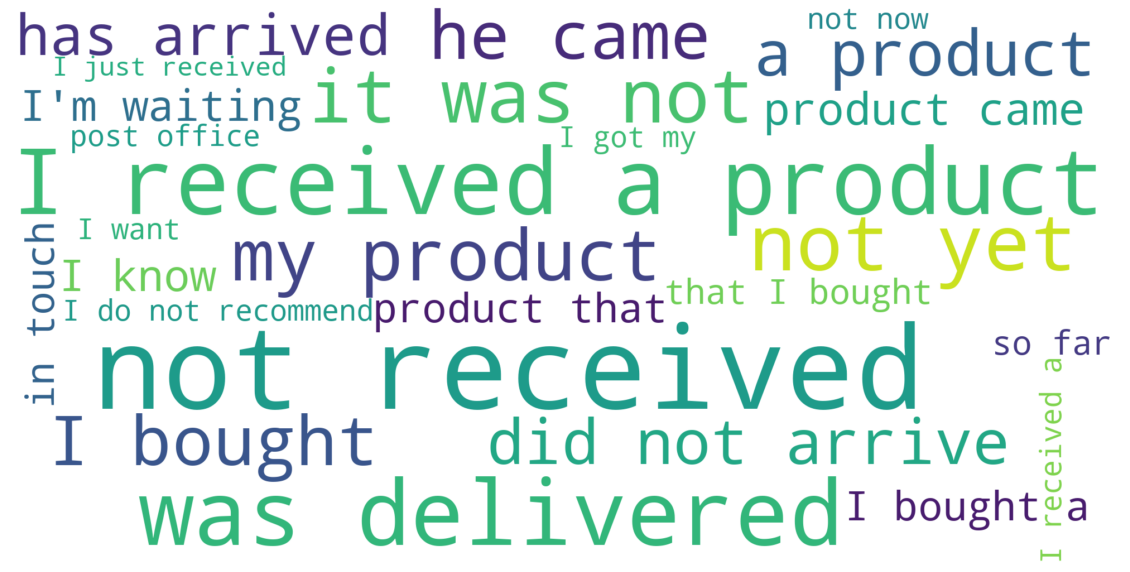

In [48]:
# Filter negative reviews
df_negative_reviews = completed_orders[completed_orders["review_score"]  == 1]
df_negative_reviews = df_negative_reviews[['order_id','customer_id','review_score']] 
df_negative_reviews = pd.merge(df_negative_reviews, order_reviews, on=["order_id"])

# seperating the reviews and the titles and dropping the missing rows seperately so that we don't have unequal shapes of rows.
review_data_title = df_negative_reviews['review_comment_title']
review_data = df_negative_reviews.drop(['review_comment_title'],axis=1)

# Dropping NaN values
review_data  = review_data.dropna()
review_data_title = review_data_title.dropna()


# Resetting the reviews index and visualizing the data
review_data = review_data.reset_index(drop=True)

# get the most frequent words
text = " ".join(review_data['review_comment_message'])
from operator import itemgetter
wordcloud_frequencies = WordCloud(width = 2000, height = 1000,background_color='white').process_text(text)
wordcloud_frequencies = sorted(wordcloud_frequencies.items(), key=itemgetter(1), reverse=True)[:70]

# wordcloud_frequencies

# translate review messages to english
translator = Translator()
translated_wordcloud_frequencies = {}
for key, value in wordcloud_frequencies:
      translated_wordcloud_frequencies[translator.translate(key).text] = value

# exclude single words
translated_wordcloud_frequencies_bigram = {}
for key, value in translated_wordcloud_frequencies.items():
  if len(key.split()) >= 2:
    translated_wordcloud_frequencies_bigram[key] = value
  
# translated_wordcloud_frequencies_bigram

# create wordcloud after translation
wordcloud = WordCloud(width = 2000, height = 1000,background_color="white").generate_from_frequencies(translated_wordcloud_frequencies_bigram)

plt.figure(figsize=(20,12))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")

plt.show()

# Bottlenecks In Delivery Chain

## Transportiation of products from logistics center to customer is the biggest bottleneck in the delivery chain

In [49]:
row1 = late_deliveries[['days_taken_from_approval_to_drop_off', 'days_taken_for_items_to_reach_customer_after_drop_off']].mean()
row2 = ontime_deliveries[['days_taken_from_approval_to_drop_off', 'days_taken_for_items_to_reach_customer_after_drop_off']].mean()

delivery = ['Ontime Deliveries', 'Late Deliveries']

fig = go.Figure()
fig.add_trace(go.Bar(
    y=delivery,
    x=[row2.days_taken_from_approval_to_drop_off, row1.days_taken_from_approval_to_drop_off],
    name='Avg inbound shipping days',
    orientation='h',
    text = [ 
                f"{math.ceil(row2.days_taken_from_approval_to_drop_off)}", 
                f"{math.ceil(row1.days_taken_from_approval_to_drop_off)}"
                ]
))
fig.add_trace(go.Bar(
    y=delivery,
    x=[row2.days_taken_for_items_to_reach_customer_after_drop_off, row1.days_taken_for_items_to_reach_customer_after_drop_off],
    name='Avg outbound shipping days',
    orientation='h',
    text = [ 
                f"{math.ceil(row2.days_taken_for_items_to_reach_customer_after_drop_off)}", 
                f"{math.ceil(row1.days_taken_for_items_to_reach_customer_after_drop_off)}"
                ]
))

fig.update_layout(barmode='stack',
                  title='Average time taken from order to delivery')
fig.show()

# Shipping Cost Analysis



## Do fuel prices affect freight charges?

In [22]:
fuel_prices = pd.read_csv('fuel_prices_2004-2021.tsv', delimiter = '\t')
# fuel_prices

In [23]:
# translate columns to english
dict = {'DATA INICIAL':'initial_date',
'DATA FINAL':'end_date',
'REGIÃO':'regions',
'ESTADO':'state',
'PRODUTO':'product',
'NÚMERO DE POSTOS PESQUISADOS':'num_gas_station/stations_consulted',
'UNIDADE DE MEDIDA':'unit',
'PREÇO MÉDIO REVENDA':'mean_market_price',
'DESVIO PADRÃO REVENDA':'sd_market_price',
'PREÇO MÍNIMO REVENDA':'min_market_price',
'PREÇO MÁXIMO REVENDA':'max_market_price',
'MARGEM MÉDIA REVENDA':'mean_price_margin',
'COEF DE VARIAÇÃO REVENDA':'coef_variance_market_price',
'PREÇO MÉDIO DISTRIBUIÇÃO':'mean_dist_price',
'DESVIO PADRÃO DISTRIBUIÇÃO':'sd_distribution_price',
'PREÇO MÍNIMO DISTRIBUIÇÃO':'min_distribution_price',
'PREÇO MÁXIMO DISTRIBUIÇÃO':'max_distribution_price',
'COEF DE VARIAÇÃO DISTRIBUIÇÃO':'coeff_variance_distribution_price'}
 
fuel_prices.rename(columns=dict, inplace=True)
fuel_prices

,initial_date,end_date,regions,state,product,num_gas_station/stations_consulted,unit,mean_market_price,sd_market_price,min_market_price,max_market_price,mean_price_margin,coef_variance_market_price,mean_dist_price,sd_distribution_price,min_distribution_price,max_distribution_price,coeff_variance_distribution_price
0,2004-05-09,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ETANOL HIDRATADO,127,R$/l,1.288,0.016,1.190,1.350,0.463,0.012,0.825,0.11,0.4201,0.9666,0.133
1,2004-05-09,2004-05-15,CENTRO OESTE,GOIAS,ETANOL HIDRATADO,387,R$/l,1.162,0.114,0.890,1.449,0.399,0.098,0.763,0.088,0.5013,1.05,0.115
2,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO,ETANOL HIDRATADO,192,R$/l,1.389,0.097,1.180,1.760,0.419,0.070,0.97,0.095,0.5614,1.161,0.098
3,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO DO SUL,ETANOL HIDRATADO,162,R$/l,1.262,0.070,1.090,1.509,0.432,0.055,0.83,0.119,0.5991,1.22242,0.143
4,2004-05-09,2004-05-15,NORDESTE,ALAGOAS,ETANOL HIDRATADO,103,R$/l,1.181,0.078,1.050,1.400,0.24,0.066,0.941,0.077,0.7441,1.0317,0.082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120818,2021-04-25,2021-05-01,NORTE,RORAIMA,OLEO DIESEL S10,12,R$/l,4.582,0.056,4.510,4.690,-99999.0,0.012,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
120819,2021-04-25,2021-05-01,SUL,SANTA CATARINA,OLEO DIESEL S10,100,R$/l,4.141,0.187,3.838,4.739,-99999.0,0.045,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
120820,2021-04-25,2021-05-01,SUDESTE,SAO PAULO,OLEO DIESEL S10,886,R$/l,4.246,0.216,3.769,5.199,-99999.0,0.051,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
120821,2021-04-25,2021-05-01,NORDESTE,SERGIPE,OLEO DIESEL S10,33,R$/l,4.464,0.205,4.190,4.699,-99999.0,0.046,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0


In [ ]:
# in the fuel prices dataset, filter to data from Sep 1, 2016 to Sep 1, 2018 and the 3 states
df1 = fuel_prices.loc[("2016-09-01" <= fuel_prices['initial_date']) & (fuel_prices['end_date'] < "2018-09-01") & ((fuel_prices['state'] == 'SAO PAULO') | (fuel_prices['state'] == 'RIO DE JANEIRO') | (fuel_prices['state'] == 'MINAS GERAIS'))].copy()
df1 = df1[['initial_date', 'end_date', 'regions', 'state', 'product', 'unit', 'mean_market_price']]

# translates oil product types from portuguese to english
product = df1['product'].unique()

product_english = {}
for key in product:
    translator = Translator()
    eng_text = translator.translate(key).text
    eng_text = re.sub(r"[^a-zA-Z0-9]+", ' ', eng_text.lower())
    product_english[key] = eng_text.strip()

df1['product_english'] = df1['product'].replace(product_english, regex=True)
df1.head(20)
# product_english

,initial_date,end_date,regions,state,product,unit,mean_market_price,product_english
84685,2016-09-04,2016-09-10,SUDESTE,MINAS GERAIS,ETANOL HIDRATADO,R$/l,2.541,hydrous ethanol
84691,2016-09-04,2016-09-10,SUDESTE,RIO DE JANEIRO,ETANOL HIDRATADO,R$/l,3.160,hydrous ethanol
84697,2016-09-04,2016-09-10,SUDESTE,SAO PAULO,ETANOL HIDRATADO,R$/l,2.289,hydrous ethanol
84712,2016-09-04,2016-09-10,SUDESTE,MINAS GERAIS,ÓLEO DIESEL,R$/l,3.002,diesel oil
84718,2016-09-04,2016-09-10,SUDESTE,RIO DE JANEIRO,ÓLEO DIESEL,R$/l,3.108,diesel oil
84724,2016-09-04,2016-09-10,SUDESTE,SAO PAULO,ÓLEO DIESEL,R$/l,2.915,diesel oil
84739,2016-09-04,2016-09-10,SUDESTE,MINAS GERAIS,ÓLEO DIESEL S10,R$/l,3.134,diesel oil S10
84745,2016-09-04,2016-09-10,SUDESTE,RIO DE JANEIRO,ÓLEO DIESEL S10,R$/l,3.269,diesel oil S10
84751,2016-09-04,2016-09-10,SUDESTE,SAO PAULO,ÓLEO DIESEL S10,R$/l,3.057,diesel oil S10
84766,2016-09-04,2016-09-10,SUDESTE,MINAS GERAIS,GASOLINA COMUM,R$/l,3.678,common gasoline


## Gasoline and diesel prices are correlated to freight charges

In [ ]:
# filter to data containing common gasoline 
common_gasoline_df = df1.loc[(df1['product_english'] == 'common gasoline')].copy()
common_gasoline_df['initial_date'] = pd.to_datetime(common_gasoline_df['initial_date'])
common_gasoline_fig = px.scatter(common_gasoline_df, x='initial_date', y='mean_market_price', color='state', trendline="lowess", title="Price of Gasoline")
common_gasoline_fig.update_traces(marker = {"size": 3})
common_gasoline_fig.show()

In [ ]:
# filter to data containing diesel oil
diesel_df = df1.loc[(df1['product_english'] == 'diesel oil')].copy()
diesel_df['initial_date'] = pd.to_datetime(diesel_df['initial_date'])
diesel_fig = px.scatter(diesel_df, x='initial_date', y='mean_market_price', color='state', trendline="lowess", title="Price of Diesel")
diesel_fig.update_traces(marker = {"size": 3})
diesel_fig.show()

In [ ]:
# plot a line chart showing average freight value
freight_value_df = completed_orders.copy()
freight_value_df["order_purchase_timestamp_dateonly"] = pd.to_datetime(freight_value_df["order_purchase_timestamp"]).dt.date
freight_value_df = freight_value_df.groupby(["customer_state", "order_purchase_timestamp_dateonly"], as_index=False).mean()
freight_value_df["order_purchase_timestamp_dateonly"] = pd.to_datetime(freight_value_df["order_purchase_timestamp_dateonly"])
freight_value_fig = px.scatter(freight_value_df, x='order_purchase_timestamp_dateonly', y='freight_value', color='customer_state', trendline="lowess", title="Average Freight Value Per Item")
freight_value_fig.update_traces(marker = {"size": 3})
freight_value_fig.show()